# Churn Telco
---

# Análisis de Churn de Clientes en Telecomunicaciones
## Framework Completo de Análisis

---

## **Abstract**

El churn de clientes representa uno de los mayores desafíos para las empresas de telecomunicaciones, con costos de adquisición de nuevos clientes que superan 5-25 veces el costo de retener clientes existentes. Este análisis desarrollará un sistema predictivo de propensión al churn utilizando técnicas de machine learning sobre datos transaccionales y demográficos de clientes.

*Objetivo*
* Construccion de un ML de clasificacion binaria
* Validar cuales son las caracteristicas mas influyentes en este modelo

**Metodología**: Análisis exploratorio de datos, ingeniería de features, modelado predictivo con algoritmos de clasificación, y validación del modelo mediante métricas de negocio.

**Impacto Esperado**: Reducción del 15-25% en la tasa de churn mediante identificación temprana y estrategias de retención dirigidas.

---

## **Hipótesis de Análisis**

### **H1: Hipótesis de Lealtad Temporal**
- **Hipótesis**: Los clientes con mayor tenure (antigüedad) tienen menor propensión al churn
- **Justificación**: La inversión de tiempo y la familiaridad con el servicio crean barreras de salida
- **Test**: Correlación negativa entre tenure y churn rate

### **H2: Hipótesis de Compromiso Contractual**
- **Hipótesis**: Los contratos de largo plazo (2 años) reducen significativamente el churn vs. month-to-month
- **Justificación**: Los contratos largos implican penalizaciones por cancelación anticipada
- **Test**: Comparación de churn rates por tipo de contrato

### **H3: Hipótesis de Valor Percibido**
- **Hipótesis**: Existe una relación U-invertida entre MonthlyCharges y churn (churn alto en extremos de precio)
- **Justificación**: Clientes con precios muy bajos pueden tener servicios limitados; precios muy altos generan sensibilidad al costo
- **Test**: Análisis de churn rate por quintiles de precio

### **H4: Hipótesis de Servicios Adicionales**
- **Hipótesis**: Los clientes con servicios de valor agregado (OnlineSecurity, TechSupport) tienen menor churn
- **Justificación**: Más servicios incrementan el switching cost y la dependencia
- **Test**: Churn rate por número de servicios adicionales contratados

### **H5: Hipótesis Demográfica**
- **Hipótesis**: Los adultos mayores sin dependientes tienen mayor propensión al churn
- **Justificación**: Menor tolerancia a la tecnología y menos necesidades de conectividad familiar
- **Test**: Segmentación por SeniorCitizen + Dependents

### **H6: Hipótesis de Método de Pago**
- **Hipótesis**: Los métodos de pago automáticos reducen el churn vs. pagos manuales
- **Justificación**: Mayor fricción en pagos manuales puede generar insatisfacción
- **Test**: Churn rate por PaymentMethod

---

In [85]:
import sqlite3
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# setting display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [86]:
def pandas_sqlite_read(db_path, query, params=None):
    with sqlite3.connect(db_path) as conn:
        # Leer directamente a DataFrame
        if params:
            df = pd.read_sql_query(query, conn, params=params)
        else:
            df = pd.read_sql_query(query, conn)
    
    return df



class ChurnDatabase:
    
    def __init__(self, db_path):
        self.db_path = db_path
        
    def get_all_customers(self):
        query = "SELECT * FROM telco_customer_churn"
        return pandas_sqlite_read(self.db_path, query)
    
    def get_churn_customers(self):
        query = "SELECT * FROM telco_customer_churn WHERE Churn = 'Yes'"
        return pandas_sqlite_read(self.db_path, query)
    
    def get_customers_by_contract(self, contract_type):
        query = "SELECT * FROM telco_customer_churn WHERE Contract = ?"
        return pandas_sqlite_read(self.db_path, query, params=[contract_type])
    
    def get_high_value_customers(self, min_charges):
        query = """
        SELECT customerID, gender, tenure, Contract, 
               MonthlyCharges, TotalCharges, Churn
        FROM telco_customer_churn
        WHERE TotalCharges > ?
        ORDER BY TotalCharges DESC
        """
        return pandas_sqlite_read(self.db_path, query, params=[min_charges])
    
    def get_churn_analysis_data(self):
        
        query = """
        SELECT 
            gender,
            SeniorCitizen,
            Partner,
            Dependents,
            tenure,
            PhoneService,
            MultipleLines,
            InternetService,
            OnlineSecurity,
            OnlineBackup,
            DeviceProtection,
            TechSupport,
            StreamingTV,
            StreamingMovies,
            Contract,
            PaperlessBilling,
            PaymentMethod,
            MonthlyCharges,
            TotalCharges,
            Churn,
            -- Features derivadas
            CASE 
                WHEN tenure <= 12 THEN 'New'
                WHEN tenure <= 36 THEN 'Regular' 
                ELSE 'Loyal'
            END as customer_segment,
            
            CASE 
                WHEN MonthlyCharges < 35 THEN 'Low'
                WHEN MonthlyCharges < 65 THEN 'Medium'
                ELSE 'High'
            END as price_segment,
            
            -- Número de servicios adicionales
            (CASE WHEN OnlineSecurity = 'Yes' THEN 1 ELSE 0 END +
             CASE WHEN OnlineBackup = 'Yes' THEN 1 ELSE 0 END +
             CASE WHEN DeviceProtection = 'Yes' THEN 1 ELSE 0 END +
             CASE WHEN TechSupport = 'Yes' THEN 1 ELSE 0 END +
             CASE WHEN StreamingTV = 'Yes' THEN 1 ELSE 0 END +
             CASE WHEN StreamingMovies = 'Yes' THEN 1 ELSE 0 END) as additional_services
             
        FROM telco_customer_churn
        """
        return pandas_sqlite_read(self.db_path, query)
    
    def get_churn_summary_stats(self):

        query = """
        SELECT 
            Contract,
            PaymentMethod,
            COUNT(*) as total_customers,
            SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) as churn_customers,
            ROUND(
                100.0 * SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*), 
                2
            ) as churn_rate,
            ROUND(AVG(MonthlyCharges), 2) as avg_monthly_charges,
            ROUND(AVG(tenure), 2) as avg_tenure
        FROM telco_customer_churn
        GROUP BY Contract, PaymentMethod
        ORDER BY churn_rate DESC
        """
        return pandas_sqlite_read(self.db_path, query)
    
    def get_dataframe_by_query(self,query:str):
        return pandas_sqlite_read(self.db_path, query)

In [87]:
churn = ChurnDatabase("../database/telco_customer_churn.sqlite.db")

In [88]:
churn.get_churn_summary_stats()

,Contract,PaymentMethod,total_customers,churn_customers,churn_rate,avg_monthly_charges,avg_tenure
0,Month-to-month,Electronic check,1850,994,53.73,74.99,17.97
1,Month-to-month,Bank transfer (automatic),589,201,34.13,69.09,24.90
2,Month-to-month,Credit card (automatic),543,178,32.78,67.68,23.96
3,Month-to-month,Mailed check,893,282,31.58,46.05,10.04
4,One year,Electronic check,347,64,18.44,79.10,46.18
5,One year,Credit card (automatic),398,41,10.30,67.97,45.48
6,One year,Bank transfer (automatic),391,38,9.72,67.48,46.02
7,Two year,Electronic check,168,13,7.74,84.34,61.11
8,One year,Mailed check,337,23,6.82,44.31,29.12
9,Two year,Bank transfer (automatic),564,19,3.37,65.01,61.60


In [89]:
df = churn.get_churn_analysis_data()

# EDA Exploracion inicial
---

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               7043 non-null   object 
 1   SeniorCitizen        7043 non-null   int64  
 2   Partner              7043 non-null   object 
 3   Dependents           7043 non-null   object 
 4   tenure               7043 non-null   int64  
 5   PhoneService         7043 non-null   object 
 6   MultipleLines        7043 non-null   object 
 7   InternetService      7043 non-null   object 
 8   OnlineSecurity       7043 non-null   object 
 9   OnlineBackup         7043 non-null   object 
 10  DeviceProtection     7043 non-null   object 
 11  TechSupport          7043 non-null   object 
 12  StreamingTV          7043 non-null   object 
 13  StreamingMovies      7043 non-null   object 
 14  Contract             7043 non-null   object 
 15  PaperlessBilling     7043 non-null   o

In [91]:
df.duplicated().any()

np.True_

In [92]:
df.isnull().sum()

gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
tenure                 0
PhoneService           0
MultipleLines          0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
Contract               0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn                  0
customer_segment       0
price_segment          0
additional_services    0
dtype: int64

In [93]:
for col in df.columns:
    print(f"Column: {col}")
    print(f"Num unique: {df[col].nunique()}")
    print("Unique values:", df[col].unique())
    print("-" * 40)



Column: gender
Num unique: 2
Unique values: ['Female' 'Male']
----------------------------------------
Column: SeniorCitizen
Num unique: 2
Unique values: [0 1]
----------------------------------------
Column: Partner
Num unique: 2
Unique values: ['Yes' 'No']
----------------------------------------
Column: Dependents
Num unique: 2
Unique values: ['No' 'Yes']
----------------------------------------
Column: tenure
Num unique: 73
Unique values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
----------------------------------------
Column: PhoneService
Num unique: 2
Unique values: ['No' 'Yes']
----------------------------------------
Column: MultipleLines
Num unique: 3
Unique values: ['No phone service' 'No' 'Yes']
----------------------------------------
Column: InternetService
Num unique: 3
Unique values: ['DSL' 

In [94]:
# Validar que no tenga columna con un valor unico
for col in df.columns:
    if len(df[col].unique())==1:
        print(f"{col}has only one unique value:{df[col].unique()}")

In [95]:

mask_empty_all = df.applymap(lambda x: isinstance(x, str) and x.strip() == '')

# Count of empty strings per column
empty_count_per_col = mask_empty_all.sum()

print("Number of empty strings per column:")
print(empty_count_per_col[empty_count_per_col != 0])

Number of empty strings per column:
TotalCharges    11
dtype: int64


### Insights de la data source: 
- 7_043 rows , 21 cols originales, agregadas algunas carcateristicas que pueden ayudar a dar algunas caracteristicas mas consistentes que otros.
The dataset contains 7,043 rows with 21 features.
- Se debe cambiar algunos datos, ajustandolos de object a float
- No hay data sucia necesariamente pero hay algunos datos en `()` y algunos con valores '' en TotalCharges
- No hay data duplicada


---

In [96]:
df["PaymentMethod"] = df.PaymentMethod.str.replace(" (automatic)","")
df.PaymentMethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'],
      dtype=object)

In [97]:
def ratio_check(serie_column: pd.Series, tope_value:float = 0.5) -> bool:

    ratio = serie_column.isna().sum() / serie_column.count()
    if ratio <= tope_value:
        
        print(f"El ratio: {ratio:.4f}, si es menor a 10% se puede imputar, si es mayor a 40% se puede retirar la columna")
    else:
        print("Cumple con caracteristicas ratio minimo")

In [98]:
#limpieza de la variable TotalCharges

df["TotalCharges"]= df["TotalCharges"].replace(" ",np.nan).replace("", np.nan)
#Convertir a valor flotante
df["TotalCharges"]= df["TotalCharges"].astype(float)
#Fill NaN con la median, pues el ratio de na/total_amount es minimo

ratio_check(df["TotalCharges"])

df["TotalCharges"]= df["TotalCharges"].fillna(df["TotalCharges"].median())


El ratio: 0.0016, si es menor a 10% se puede imputar, si es mayor a 40% se puede retirar la columna


## Analisis UniVariado

**Variable Target -> Churn**

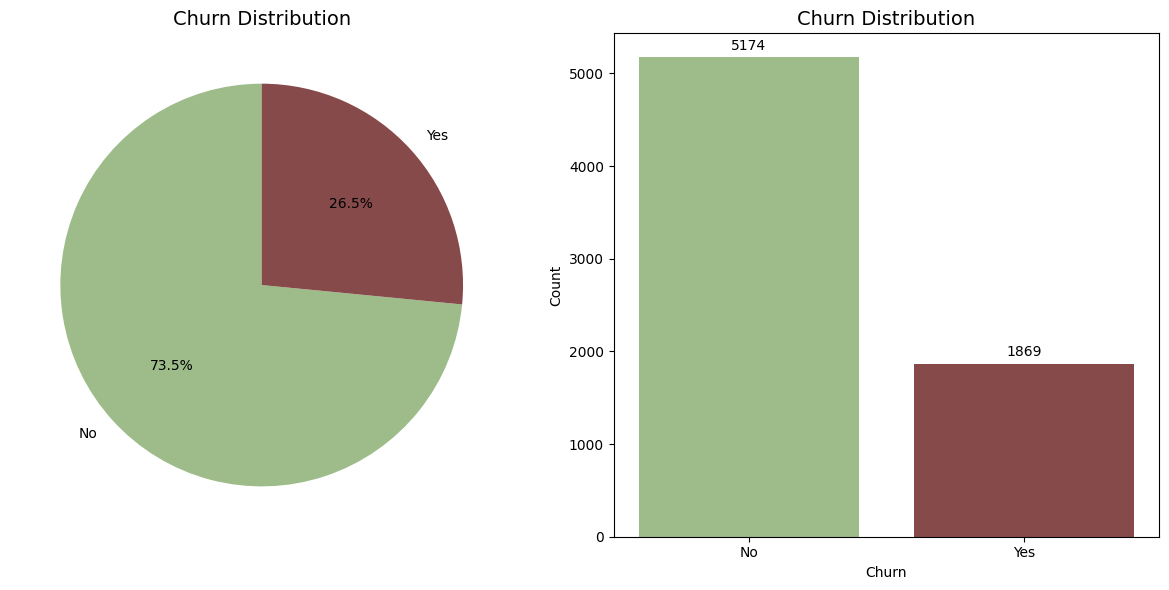

In [105]:
## Distribucion del Dato Churn
churn_counts = df['Churn'].value_counts()

# Colors mapping
colors = {'Yes': '#874A4A', 'No': '#9EBC8A'}

# Create subplot (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart 
axes[0].pie(
    churn_counts,
    labels=churn_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=[colors[label] for label in churn_counts.index]
)

axes[0].set_title('Churn Distribution', fontsize=14)

# Bar chart 
bars = axes[1].bar(
    churn_counts.index,
    churn_counts.values,
    color=[colors[label] for label in churn_counts.index]
)

# Add numeric labels on top of bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width()/2, 
        height + (0.01 * max(churn_counts.values)),  # a bit above the bar
        f'{int(height)}', 
        ha='center', va='bottom', fontsize=10
    )

axes[1].set_title('Churn Distribution', fontsize=14)
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Churn')

# Adjust layout
plt.tight_layout()
plt.show()



*Claramente observamos un desbalance de la cantidad de datos en la variable predictoria*

In [ ]:
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'Contract', 'PaperlessBilling', 'PaymentMethod']

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [99]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer

# --- Columnas ---

bin_cols = ["gender","Partner","Dependents","PhoneService","PaperlessBilling","Churn"]
ordinal_cols = ["customer_segment", "price_segment", "additional_services"]
multi_cols_for_dummies = [
    "MultipleLines","InternetService","OnlineSecurity","OnlineBackup",
    "DeviceProtection","TechSupport","StreamingTV","StreamingMovies",
    "Contract","PaymentMethod"
]

mapper_columns_bins = {"Yes":1, "No":0, "Male":1, "Female":0}

ordinal_categories = [
    ["New", "Regular", "Loyal"],   # customer_segment
    ["Low", "Medium", "High"],     # price_segment
    [0, 1, 2, 3, 4, 5, 6]          # additional_services
]

# --- Transformadores ---
bin_transformer = FunctionTransformer(
    lambda x: x.replace(mapper_columns_bins)
)

ordinal_transformer = OrdinalEncoder(categories=ordinal_categories)

multi_transformer = OneHotEncoder(handle_unknown="ignore")

# --- ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ("bin", bin_transformer, bin_cols),
        ("ord", ordinal_transformer, ordinal_cols),
        ("multi", multi_transformer, multi_cols_for_dummies)
    ],
    # deja el resto tal cual (ej: columnas numéricas)
    remainder="passthrough"
)


pipe = Pipeline(steps=[
    ("preprocessor", preprocessor)
])


### Datos completamente numericos para analisis del tipo de correlacion

In [104]:
# Transformamos los datos
df_cleaned = pipe.fit_transform(df)

# Columnas binarias
bin_features = bin_cols

# Columnas ordinales
ord_features = pipe.named_steps["preprocessor"].named_transformers_["ord"].get_feature_names_out(ordinal_cols)

# Columnas one-hot
multi_features = pipe.named_steps["preprocessor"].named_transformers_["multi"].get_feature_names_out(multi_cols_for_dummies)

# Columnas pasadas por remainder
remainder_features = [
    col for col in df.columns
    if col not in bin_cols + ordinal_cols + multi_cols_for_dummies
]

# Concatenamos todos los nombres
all_features = np.concatenate([bin_features, ord_features, multi_features, remainder_features])

# Convertimos a DataFrame
df_trans = pd.DataFrame(df_cleaned.toarray() if hasattr(df_cleaned, "toarray") else df_cleaned,
                        columns=all_features)

print(df_trans.shape)

df_trans.head()


(7043, 44)


,gender,Partner,Dependents,PhoneService,PaperlessBilling,Churn,customer_segment,price_segment,additional_services,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,29.85,29.85
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,34.0,56.95,1889.50
2,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,53.85,108.15
3,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,45.0,42.30,1840.75
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,70.70,151.65
